In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install duckdb
import duckdb
con = duckdb.connect()

df_train = con.query(f"""(SELECT *
                        FROM parquet_scan('/kaggle/input/belka-shrunken-train-set/train.parquet')
                        WHERE binds_sEH = 0
                        ORDER BY random()
                        LIMIT 12000)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('/kaggle/input/belka-shrunken-train-set/train.parquet')
                        WHERE binds_sEH = 1
                        ORDER BY random()
                        LIMIT 12000)""").df()

df_test = con.query(f"""(SELECT *
                        FROM parquet_scan('/kaggle/input/belka-shrunken-train-set/test.parquet')
                        WHERE is_sEH = 0
                        ORDER BY random()
                        LIMIT 3000)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('/kaggle/input/belka-shrunken-train-set/test.parquet')
                        WHERE is_sEH = 1
                        ORDER BY random()
                        LIMIT 3000)""").df()

con.close()

print("training Data:", df_train.shape)
print("testing Data:", df_test.shape)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.6 MB/s eta 0:00:00:00:0100:01


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

training Data: (24000, 7)
testing Data: (6000, 7)


In [3]:
print(df_train)

       buildingblock1_smiles  buildingblock2_smiles  buildingblock3_smiles  \
0                        134                    669                    505   
1                        230                     97                    609   
2                        147                    588                    781   
3                        137                    551                    127   
4                         94                    197                    654   
...                      ...                    ...                    ...   
23995                     75                    351                    551   
23996                     76                    257                    817   
23997                     67                    245                    430   
23998                     75                    148                    669   
23999                     75                    491                    334   

                                         molecule_smiles  binds

In [4]:
from collections import Counter
Counter(df_train["binds_HSA"])






Counter({0: 22638, 1: 1362})

In [5]:
Counter(df_train["binds_BRD4"])

Counter({0: 23943, 1: 57})

In [6]:
Counter(df_train["binds_sEH"])

Counter({0: 12000, 1: 12000})

In [7]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 53.3 MB/s eta 0:00:00:00:0100:01


In [8]:
%%capture
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import RDLogger # Suppress RDKit warnings RDLogger.DisableLog('rdApp.*')
import warnings
warnings.filterwarnings('ignore')

generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)

ecfp_train= []
for smiles in df_train["molecule_smiles"]:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Generate ECFP fingerprint for the molecule
        fp = generator.GetFingerprint(mol)
        # Convert RDKit's ExplicitBitVect to a numpy array
        fp_array = np.zeros((1024,), dtype=int)
        Chem.DataStructs.ConvertToNumpyArray(fp, fp_array)
        ecfp_train.append(fp_array)
    else:
        print(f"Invalid SMILES: {smiles}")
        ecfp_train.append(None)    

ecfp_test = []
for smiles in df_test["molecule_smiles"]:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = generator.GetFingerprint(mol)
        fp_array = np.zeros((1204), dtype=int)
        Chem.DataStructs.ConvertToNumpyArray(fp, fp_array)
        ecfp_test.append(fp_array)
    else:
        print(f"Invalid SMILES: {smiles}")
        ecfp_test.append(None)    



        
ecfp_train = np.array([fp for fp in ecfp_train if fp is not None])
ecfp_test = np.array([fp for fp in ecfp_test if fp is not None])

In [9]:
print(ecfp_train)


[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train = pd.DataFrame(ecfp_train)
X_test = pd.DataFrame(ecfp_test)

y_train = df_train['binds_sEH']
y_test = df_test['is_sEH']

#print("X_train", X_train)
#print("X_test", X_test)

logreg_model = LogisticRegression()

logreg_model.fit(X_train, y_train) 

y_pred = logreg_model.predict(X_test) 
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print(y_pred)

Test Accuracy: 0.4845
[0 0 0 ... 0 0 0]


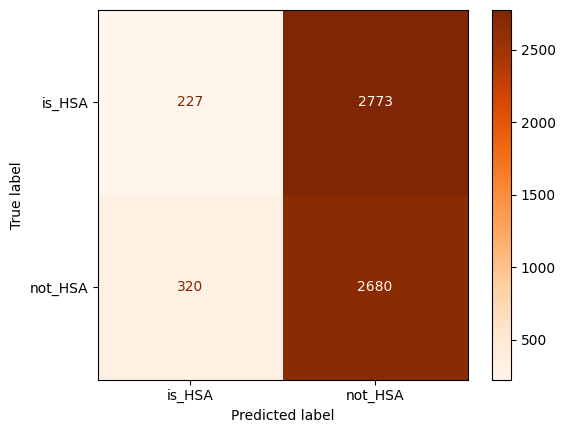

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels = [1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["is_HSA", "not_HSA"])
disp.plot(cmap='Oranges');

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
precision = precision_score(y_test, y_pred)
print(precision)

0.5101666666666667
0.7074829931972789


Accuracy: 49.23%


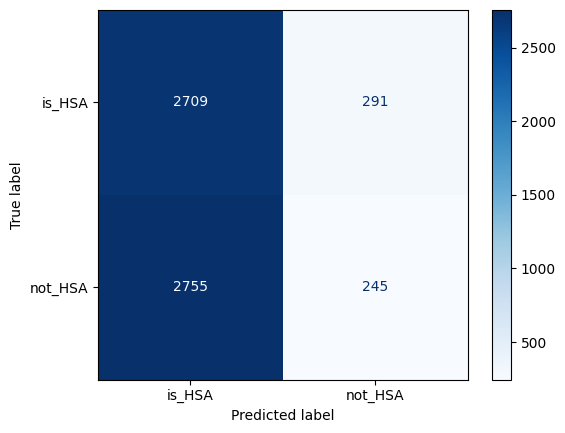

In [13]:
# Import necessary libraries

from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt


# Split the dataset into training and testing sets (80% train, 20% test)

# Create a Decision Tree Classifier model
clf = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["is_HSA", "not_HSA"])
disp.plot(cmap='Blues')
plt.show()

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Embedding
from sklearn.model_selection import train_test_split


# Assuming X_train and X_test are currently 2D arrays of shape (samples, sequence_length)
print(X_train.shape)  # Check the shape before expanding dimensions

# Correctly reshape input to be 3D: (samples, sequence_length, features)
X_train_3d = np.expand_dims(X_train, axis=-1) 
X_test = np.expand_dims(X_test, axis=-1)   

print(X_train_3d.shape)  # Check the shape after expansion to confirm it's (samples, sequence_length, 1)

X_val, X_final_test, y_val, y_final_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(1024, 1)))  # Sequence length 1024, 1 feature
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Train the model
model.fit(X_train_3d, y_train, epochs=6, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy, precision, recall = model.evaluate(X_final_test, y_final_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")

(24000, 1024)
(24000, 1024, 1)
Epoch 1/6


I0000 00:00:1749676857.931448     121 service.cc:145] XLA service 0x7fde64004d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749676857.931488     121 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749676857.931492     121 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 24/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5842 - loss: 0.7280 - precision: 0.5467 - recall: 0.6168

I0000 00:00:1749676860.139512     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8569 - loss: 0.3268 - precision: 0.8744 - recall: 0.8320 - val_accuracy: 0.5010 - val_loss: 1.9065 - val_precision: 0.6250 - val_recall: 0.0523
Epoch 2/6
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9456 - loss: 0.1507 - precision: 0.9474 - recall: 0.9443 - val_accuracy: 0.5063 - val_loss: 2.3726 - val_precision: 0.6622 - val_recall: 0.0641
Epoch 3/6
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9549 - loss: 0.1200 - precision: 0.9552 - recall: 0.9544 - val_accuracy: 0.5027 - val_loss: 2.5400 - val_precision: 0.7500 - val_recall: 0.0373
Epoch 4/6
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9673 - loss: 0.0930 - precision: 0.9664 - recall: 0.9684 - val_accuracy: 0.5010 - val_loss: 2.0862 - val_precision: 0.5673 - val_recall: 0.0909
Epoch 5/6
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9732 - loss: 0.0789 - precision: 0.9713 - recall: 0.9754 - val_accuracy: 0.4977 - val_loss: 3.9499 - val_pre

In [15]:
# # Step 1: Check the shape of X_train and ensure it has 24000 rows and 1024 columns
# print(X_train.shape)  # Should be (24000, 1024),1024 is length of ecfp

# # Step 2: Ensure y_train is a pandas Series with 24000 elements
# print(y_train.shape)  # Should be (24000,)

# y_train_series = pd.Series(y_train, name='label')

# print(y_train_series.head())
# # Step 3: Concatenate along axis 1 (columns)
# train_df = pd.concat([X_train, y_train_series], axis=1)

# positive_samples = train_df[train_df['label'] == 1].head(5)  # First 5 positive samples
# negative_samples = train_df[train_df['label'] == 0].head(5)  # First 5 negative samples

# # Print 5 positive samples
# print("Positive samples:")
# print(positive_samples)

# # Print 5 negative samples
# print("\nNegative samples:")
# print(negative_samples)
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["is_HSA", "not_HSA"])
# disp.plot(cmap='Blues')
# plt.show()

In [16]:
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
image_train =[]
for smiles in df_train["molecule_smiles"]:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Generate ECFP fingerprint for the molecule
        img = Draw.MolToImage(mol, size = (100, 100))
        image_train.append(img)
    else:
        print(f"Invalid SMILES: {smiles}")
        image_train.append(None)    
        
image_test =[]
for smiles in df_test["molecule_smiles"]:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Generate ECFP fingerprint for the molecule
        img = Draw.MolToImage(mol, size = (100, 100))
        image_test.append(img)
    else:
        print(f"Invalid SMILES: {smiles}")
        image_test.append(None)    

In [17]:
from PIL import Image
def preprocess_image(image, target_size=(100,100)):
    if image is not None:
        image = image.resize(target_size)
        image = image.convert('L')
        image_array = np.array(image)
        image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array)) # Normalize
        return image_array
    return None
    
image_train_processed = np.array([preprocess_image(img) for img in image_train])
image_test_processed = np.array([preprocess_image(img) for img in image_test])

# Remove None entries if any
#image_train_processed = image_train_processed[~np.array([img is None for img in image_train])]
#image_test_processed = image_test_processed[~np.array([img is None for img in image_test])]

# Reshape for CNN input (adding channel dimension)
image_train_processed = image_train_processed.reshape(-1, 100, 100, 1)  # Shape: (num_samples, 100, 100, 1)
image_test_processed = image_test_processed.reshape(-1, 100, 100, 1)  

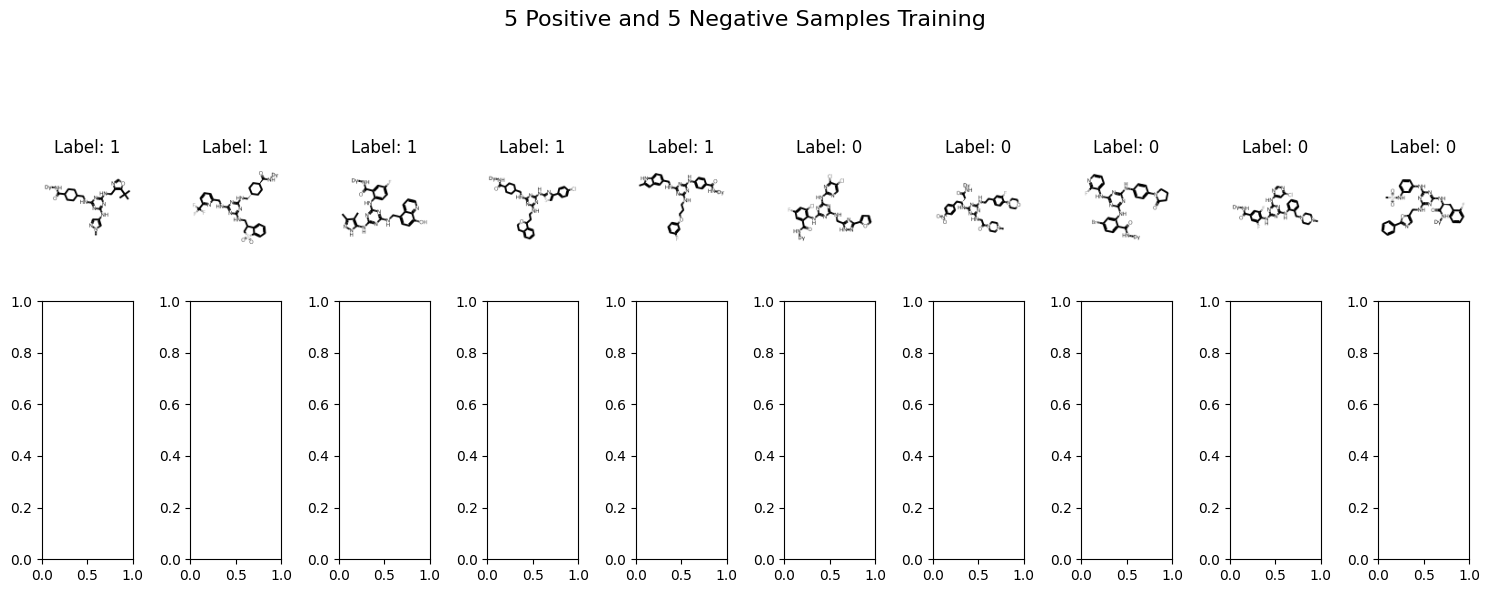

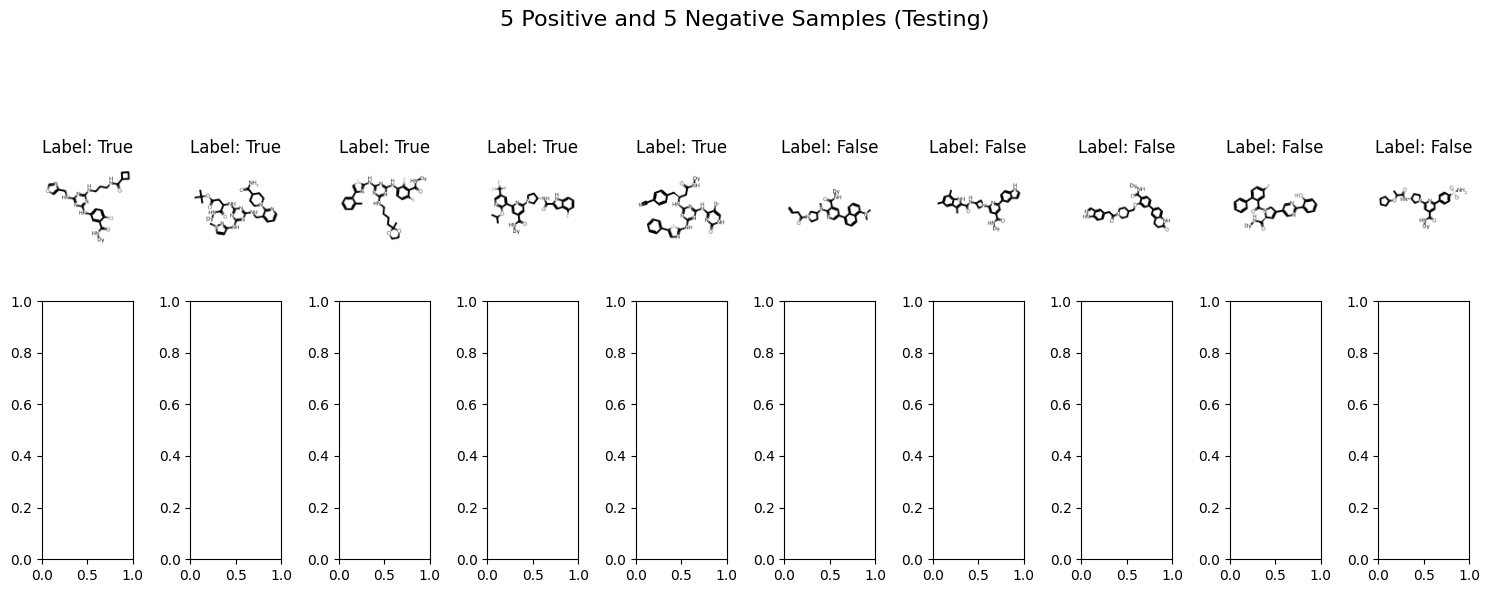

In [18]:
# Number of images to display
num_images = 10

# Select indices for positive and negative samples
positive_indices = np.where(y_train == 1)[0][:5]  # First 5 positive samples
negative_indices = np.where(y_train == 0)[0][:5]  # First 5 negative samples

# Combine the indices
indices = np.concatenate([positive_indices, negative_indices])

# Set up the figure
fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
fig.suptitle('5 Positive and 5 Negative Samples Training', fontsize=16)

# Iterate through the selected indices and display images
for i, idx in enumerate(indices):
    ax = axes[i // num_images, i % num_images]  # Row and column index
    ax.imshow(image_train_processed[idx].squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
    ax.set_title(f'Label: {y_train[idx]}')
    ax.axis('off')  # Hide axis

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for suptitle
plt.show()

# Number of images to display
num_images = 10

# Select indices for positive and negative samples
positive_indices = np.where(y_test == 1)[0][:5]  # First 5 positive samples
negative_indices = np.where(y_test == 0)[0][:5]  # First 5 negative samples

# Combine the indices
indices = np.concatenate([positive_indices, negative_indices])

# Set up the figure
fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
fig.suptitle('5 Positive and 5 Negative Samples (Testing)', fontsize=16)

# Iterate through the selected indices and display images
for i, idx in enumerate(indices):
    ax = axes[i // num_images, i % num_images]  # Row and column index
    ax.imshow(image_test_processed[idx].squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
    ax.set_title(f'Label: {y_test[idx]}')
    ax.axis('off')  # Hide axis

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for suptitle
plt.show()

Epoch 1/9
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.5569 - loss: 0.7651 - precision_1: 0.5673 - recall_1: 0.5144 - val_accuracy: 0.5000 - val_loss: 1.3669 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/9
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.6619 - loss: 0.6194 - precision_1: 0.6673 - recall_1: 0.6347 - val_accuracy: 0.5000 - val_loss: 1.2176 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/9
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.6904 - loss: 0.5895 - precision_1: 0.7081 - recall_1: 0.6485 - val_accuracy: 0.5000 - val_loss: 1.1961 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/9
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.7173 - loss: 0.5570 - precision_1: 0.7553 - recall_1: 0.6433 - val_accuracy: 0.5000 - val_loss: 1.0271 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/9
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.7384 - loss: 0.5300 - pre

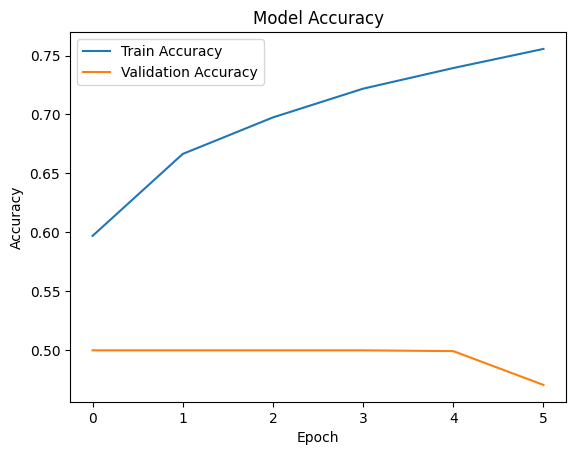

Test Loss: 1.3668668270111084
Test Accuracy: 0.5
Test Precision: 0.0
Test Recall: 0.0
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


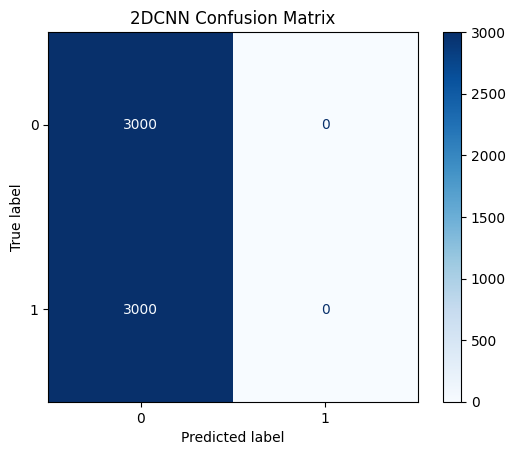

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (100,100, 1)))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#val_image, test_image = train_test_split(image_test_processed, test_size=0.5, random_state=42)
optimizer = Adam(learning_rate=0.0001)
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)#data augmentation by adding variability (e.g. rotations, flips, scaling])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
history = model.fit(datagen.flow(image_train_processed, y_train, batch_size=32), epochs=9, batch_size=32, validation_data = (image_test_processed, y_test), callbacks=[early_stopping])
loss, accuracy, precision, recall = model.evaluate(image_test_processed, y_test)

def plot_acc(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
plot_acc(history)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")

y_pred = (model.predict(image_test_processed) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap=plt.cm.Blues)
plt.title("2DCNN Confusion Matrix")
plt.show()

In [20]:
!pip install torch-geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data
from rdkit.Chem import rdmolops
from torch_geometric.data import DataLoader
from torch_geometric.nn import global_max_pool

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Invalid SMILES: {smiles}")
        return None
    adjacency_matrix = rdmolops.GetAdjacencyMatrix(mol)
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append([atom.GetAtomicNum()])
    edge_index = torch.tensor(adjacency_matrix.nonzero(), dtype=torch.long)
    x = torch.tensor(atom_features, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

class GNN(nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(1, 64)
        self.conv2 =GraphConv(64, 128)
        self.conv3 = GraphConv(128, 64)
        self.fc = torch.nn.Linear(64, 1)
        self.dropout = torch.nn.Dropout(p=0.3)
       
      
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
                            
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        

 
        x = global_max_pool(x, batch)  # Global pooling to get graph-level embedding (reduces dimensions of input by taking the maximum value over all elements)
        x = self.dropout(x)
        x = self.fc(x)
        return x

    #dtypes = {'buildingblock1_smiles': np.int16, 'buildingblock2_smiles': np.int16, 'buildingblock3_smiles': np.int16,
#          'binds_BRD4':np.byte, 'binds_HSA':np.byte, 'binds_sEH':np.byte}

#train = pd.read_csv('/kaggle/input/belka-shrunken-train-set/train.csv', dtype = dtypes)
#print(len(train))

#abridged_train = train.sample(frac=0.00001, random_state = 42)
#len(abridged_train)  
#test = pd.read_csv('/kaggle/input/belka-shrunken-train-set/test.csv', dtype = dtypes)
#print(len(test))

#abridged_test = test.sample(frac=0.001, random_state = 42)
#len(abridged_test) 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.3 MB/s eta 0:00:0000:01


Train label distribution: 0.5
Test label distribution: 0.5
Epoch 1, Train Accuracy: 0.5335, Precision: 0.5335, Recall: 0.5342
Epoch 1, Validation Accuracy: 0.7211, Validation Precision: 0.7162, Validation Recall: 0.7325
Epoch 2, Train Accuracy: 0.5744, Precision: 0.5737, Recall: 0.5792
Epoch 2, Validation Accuracy: 0.7568, Validation Precision: 0.8353, Validation Recall: 0.6398
Epoch 3, Train Accuracy: 0.5881, Precision: 0.5910, Recall: 0.5721
Epoch 3, Validation Accuracy: 0.6187, Validation Precision: 0.5742, Validation Recall: 0.9187
Epoch 4, Train Accuracy: 0.6073, Precision: 0.6055, Recall: 0.6158
Epoch 4, Validation Accuracy: 0.6869, Validation Precision: 0.6438, Validation Recall: 0.8369
Epoch 5, Train Accuracy: 0.6183, Precision: 0.6224, Recall: 0.6017
Epoch 5, Validation Accuracy: 0.7676, Validation Precision: 0.9279, Validation Recall: 0.5802
Epoch 6, Train Accuracy: 0.6252, Precision: 0.6215, Recall: 0.6404
Epoch 6, Validation Accuracy: 0.7052, Validation Precision: 0.6699, V

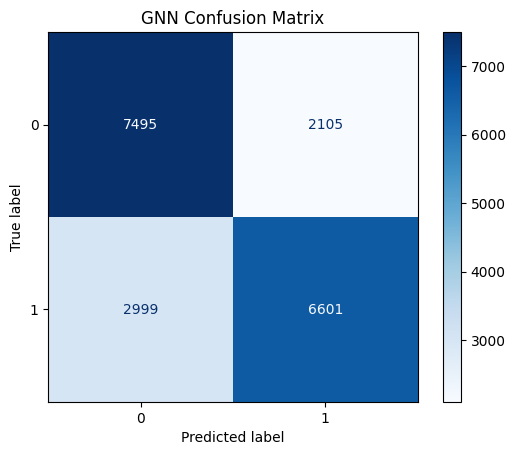

In [21]:
from sklearn.model_selection import train_test_split
criterion = torch.nn.BCEWithLogitsLoss()
graphs_train = []
for smiles in df_train['molecule_smiles']:
    graph = smiles_to_graph(smiles)
    if graph is not None:
        graphs_train.append(graph)

graphs_test = []
for smiles in df_test['molecule_smiles']: 
    graph = smiles_to_graph(smiles)
    if graph is not None:
        graphs_test.append(graph)


from torch_geometric.data import Data

for i, graph in enumerate(graphs_train):
    graph.y = torch.tensor([y_train[i]], dtype=torch.float)  # Attach each label to its corresponding graph in training set

for i, graph in enumerate(graphs_test):
    graph.y = torch.tensor([y_test[i]], dtype=torch.float)  

val_data, train_data = train_test_split(graphs_train, test_size=0.2, random_state=42, shuffle=True, stratify = y_train)#####
train_loader = DataLoader(train_data, batch_size=32, shuffle = True, drop_last = True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(graphs_test, batch_size=32)

model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print(f"Train label distribution: {sum(y_train) / len(y_train)}")
print(f"Test label distribution: {sum(y_test) / len(y_test)}")

for epoch in range(10):
    model.train()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)
        
            
        output = output.view(-1)  # Flatten the output tensor
        target = data.y.float().view(-1)
    
        loss = criterion(output,target) #y_pred, y_test
        loss.backward()
        optimizer.step()
    
        #calculate correct, total, all_preds, and all_labels separately in training and validation to ensure they are reset properly
        predicted = (torch.sigmoid(output) > 0.5).float()  
        correct += (predicted == target).sum().item()
        total += target.size(0)
        
        all_preds.extend(predicted.cpu().numpy().flatten())
        all_labels.extend(target.cpu().numpy().flatten())
        
    accuracy = correct / total
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    print(f'Epoch {epoch+1}, Train Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    
    
    
    
    # Validation loop after each epoch
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = [] 
    with torch.no_grad():
        for data in val_loader:
            output = model(data)
            output = output.view(-1)#output shape matches the batch size
            target = data.y.float().view(-1)
            predicted = (torch.sigmoid(output) > 0.5).float()  # Binary prediction
            
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            all_preds.extend(predicted.cpu().numpy().flatten())
            all_labels.extend(target.cpu().numpy().flatten())
    val_accuracy = correct / total
    val_precision = precision_score(all_labels, all_preds)
    val_recall = recall_score(all_labels, all_preds)
    print(f'Epoch {epoch+1}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}')

model.eval()
test_correct, test_total = 0,0
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for data in test_loader:
        output = model(data)
        predicted = (torch.sigmoid(output)>0.5).float()
        all_test_preds.extend(predicted.cpu().numpy().flatten())
        all_test_labels.extend(data.y.cpu().numpy().flatten())
        
accuracy = accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds)
recall = recall_score(all_test_labels, all_test_preds)
print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
model.eval()

cm = confusion_matrix(all_labels, all_preds)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap=plt.cm.Blues)
plt.title(f"GNN Confusion Matrix")
plt.show()

Training Positive samples:


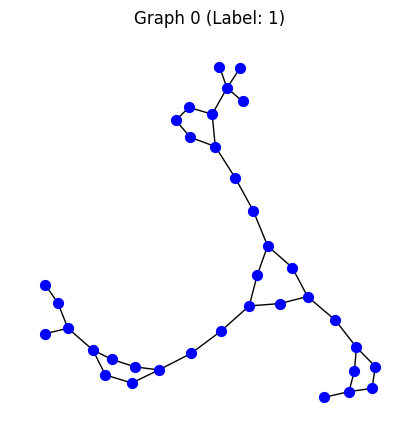

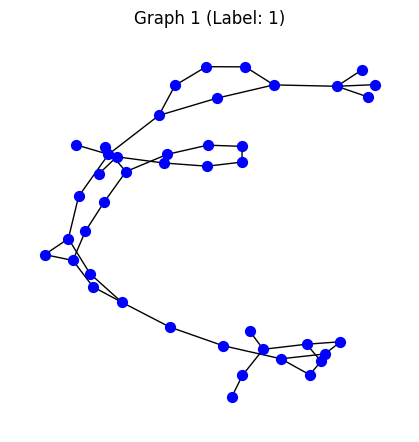

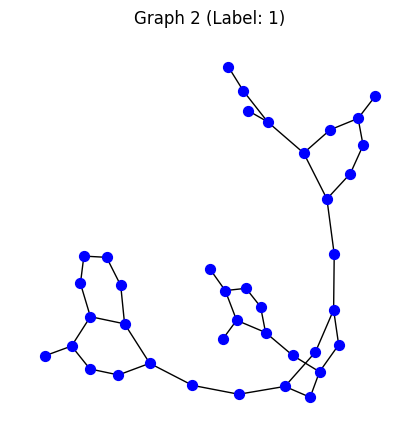

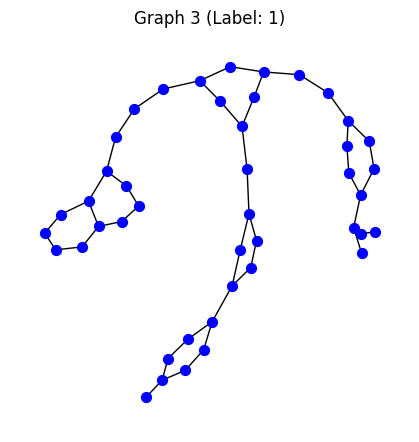

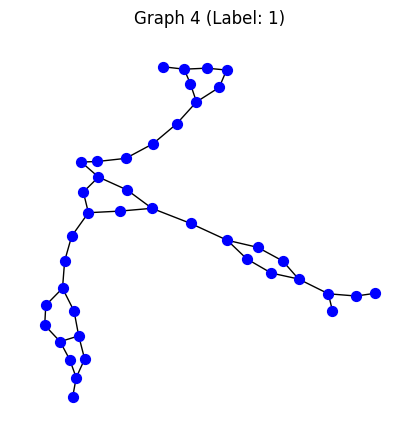

Training Negative samples:


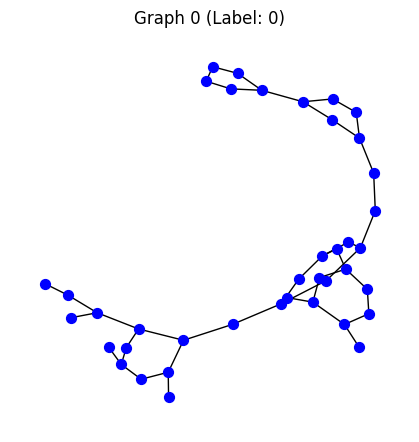

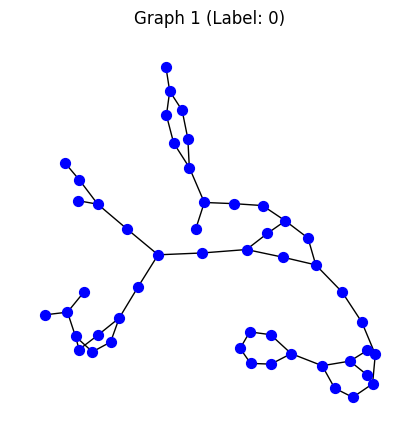

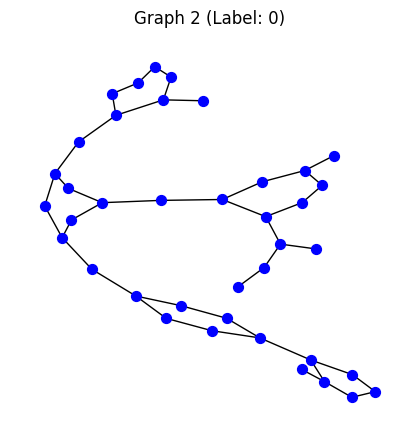

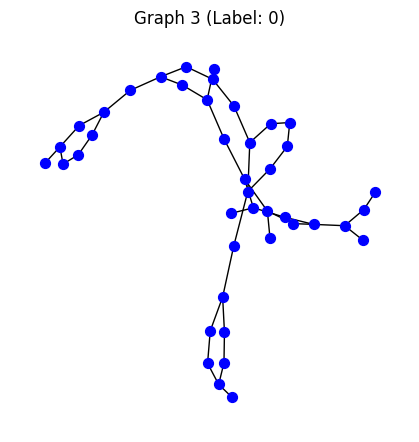

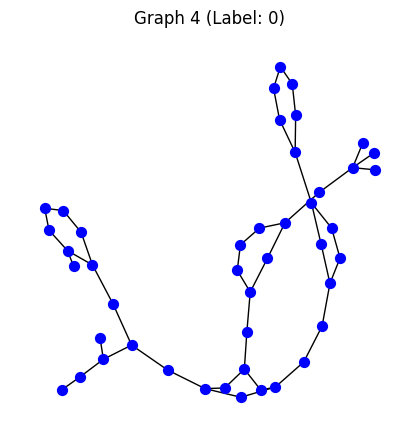

Testing Positive samples


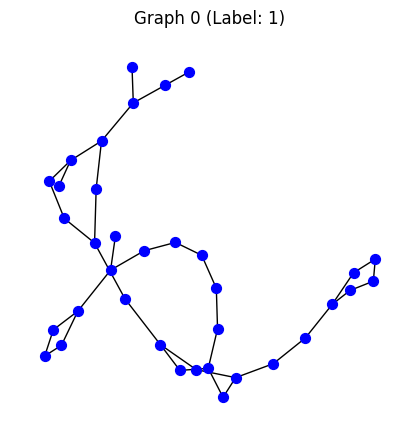

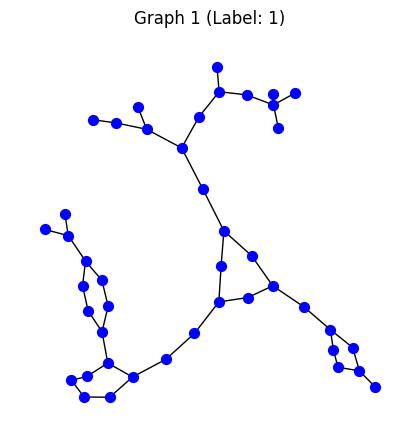

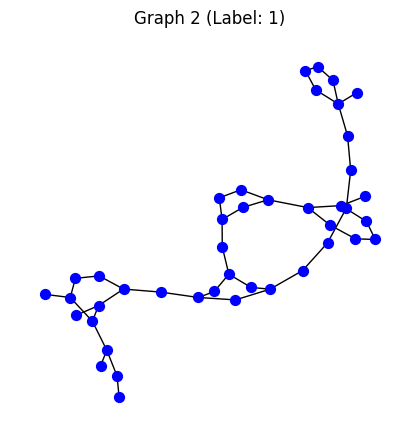

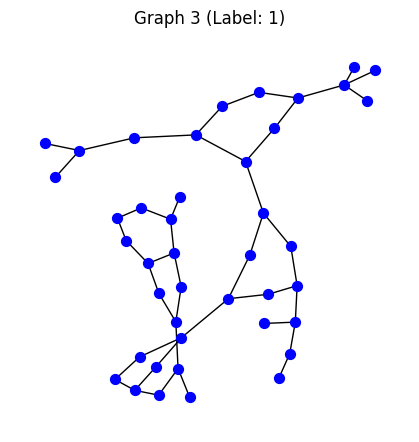

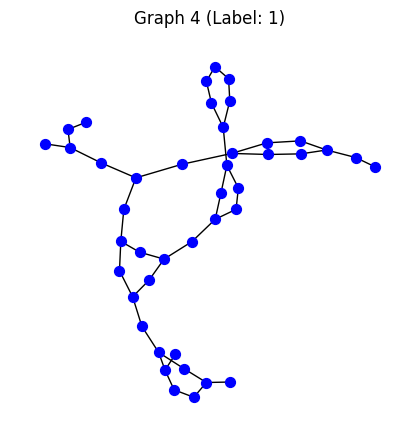

Testing Negative sample


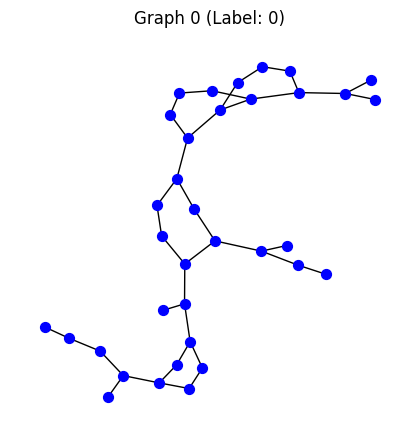

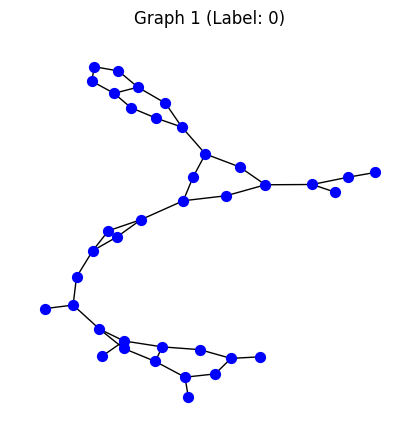

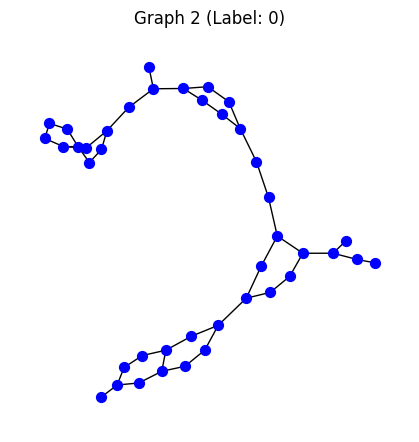

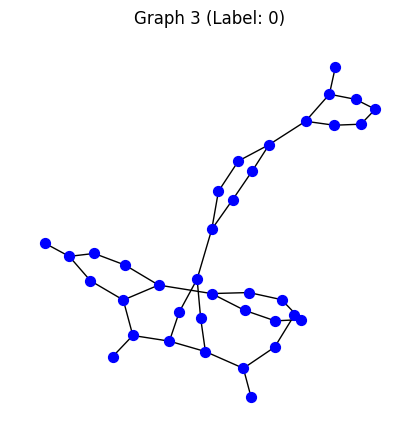

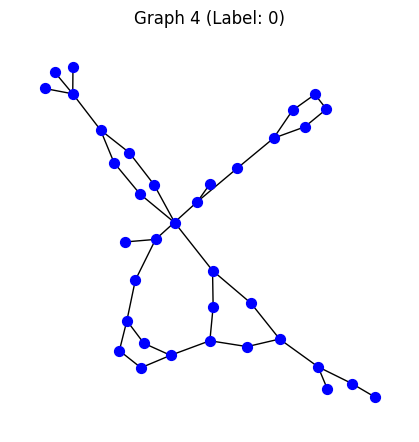

In [22]:
from torch_geometric.utils import to_networkx
import networkx as nx

# Function to plot the graph
def plot_graph(graph, label, index):
    # Convert the PyG graph to a NetworkX graph for visualization
    G = to_networkx(graph, to_undirected=True)
    plt.figure(figsize=(4, 4))
    nx.draw(G, node_size=50, node_color='blue', with_labels=False)
    plt.title(f'Graph {index} (Label: {label})')
    plt.show()

# Separate positive and negative samples from graphs_train and graphs_test
positive_samples_train = [graph for graph in graphs_train if graph.y.item() == 1][:5]
negative_samples_train = [graph for graph in graphs_train if graph.y.item() == 0][:5]

positive_samples_test = [graph for graph in graphs_test if graph.y.item() == 1][:5]
negative_samples_test = [graph for graph in graphs_test if graph.y.item() == 0][:5]


print("Training Positive samples:")
for i, graph in enumerate(positive_samples_train):
    plot_graph(graph, label=1, index=i)

print("Training Negative samples:")
for i, graph in enumerate(negative_samples_train):
    plot_graph(graph, label=0, index=i)


print("Testing Positive samples")
for i, graph in enumerate(positive_samples_test):
    plot_graph(graph, label=1, index=i)

print("Testing Negative sample")
for i, graph in enumerate(negative_samples_test):
    plot_graph(graph, label=0, index=i)











In [23]:
from rdkit.Chem import rdFingerprintGenerator

# Create a MorganGenerator instance
generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)

def get_ecfp_vector(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Generate ECFP fingerprint for the molecule using MorganGenerator
        fp = generator.GetFingerprint(mol)
        # Convert RDKit's ExplicitBitVect to a numpy array
        fp_array = np.zeros((1024,), dtype=int)
        Chem.DataStructs.ConvertToNumpyArray(fp, fp_array)
        return fp_array
    else:
        print(f"Invalid SMILES: {smiles}")
        return None  

In [24]:
from rdkit.Chem import Descriptors
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        molecular_weight = Descriptors.MolWt(mol)
        logP = Descriptors.MolLogP(mol)
        tpsa = Descriptors.TPSA(mol)
        return molecular_weight, logP, tpsa
    else:
        return None, None, None  # Return None if SMILES is invalid

In [25]:
# Assuming df_test contains both the SMILES and target values
df_val_new, df_train_new = train_test_split(df_train, test_size=0.2, random_state=42, shuffle=True, stratify=df_train["binds_sEH"])

# Generate metadata descriptors aligned with the split data
metadata_train_new = np.array([calculate_descriptors(smiles) for smiles in df_train_new['molecule_smiles']])
metadata_val_new = np.array([calculate_descriptors(smiles) for smiles in df_val_new['molecule_smiles']])
metadata_test = np.array([calculate_descriptors(smiles) for smiles in df_test['molecule_smiles']])

# Prepare your X and y datasets accordingly
X_train_new = np.array([get_ecfp_vector(smiles) for smiles in df_train_new['molecule_smiles']])
X_val_new = np.array([get_ecfp_vector(smiles) for smiles in df_val_new['molecule_smiles']])
X_final_test = np.array([get_ecfp_vector(smiles) for smiles in df_test['molecule_smiles']])

y_train_new = df_train_new['binds_sEH'].values 
y_val_new = df_val_new['binds_sEH'].values  # Replace 'target' with your actual column name
y_final_test = df_test['is_sEH'].values

Epoch 1/12


I0000 00:00:1749677315.463418     442 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_157', 1028 bytes spill stores, 1028 bytes spill loads



75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.4834 - auc: 0.4846 - loss: 10.9354 - precision_2: 0.4858 - recall_2: 0.4175 - val_accuracy: 0.5070 - val_auc: 0.6032 - val_loss: 10.7135 - val_precision_2: 0.5891 - val_recall_2: 0.0461
Epoch 2/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5063 - auc: 0.5220 - loss: 10.7491 - precision_2: 0.5185 - recall_2: 0.4424 - val_accuracy: 0.6606 - val_auc: 0.7092 - val_loss: 10.3496 - val_precision_2: 0.6731 - val_recall_2: 0.6245
Epoch 3/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5640 - auc: 0.6029 - loss: 10.3666 - precision_2: 0.5733 - recall_2: 0.5148 - val_accuracy: 0.6968 - val_auc: 0.8102 - val_loss: 9.8584 - val_precision_2: 0.6572 - val_recall_2: 0.8225
Epoch 4/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6260 - auc: 0.6728 - loss: 9.8635 - precision_2: 0.6470 - recall_2: 0.5915 - val_accuracy: 0.7439 - val_auc: 0.8487 - val_loss: 9.2477 - val_precision_2: 0.7210 - val_recall_2: 0.7956
Epoch 5/1

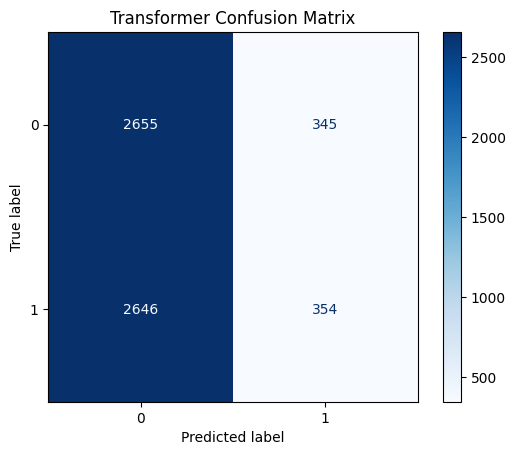

In [26]:
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, BatchNormalization, Lambda, Layer, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC, F1Score
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
# Hyperparameters
input_dim = 1024  # Size of ECFP vector
D_MODEL = 128    # Transformer model size (embedding dimension)
NUM_HEADS = 2 # Number of attention heads
DFF = 256        # Feed-forward network hidden layer size
NUM_LAYERS = 4    # Number of Transformer layers
DROPOUT_RATE = 0.3

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def call(self, q, k, v, mask):
        # Split the heads and perform scaled dot-product attention
        pass  # Implement following the tutorial
        
# 1. Transformer Encoder Layer (No need for embedding or positional encoding for ECFP)
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=DROPOUT_RATE):
        super(TransformerEncoderLayer, self).__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    
    def call(self, x, training=False):  # training flag added here
        x_norm = self.layernorm1(x)
        attn_output = self.mha(x_norm, x_norm)  # Attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = x+attn_output

        out1_norm = self.layernorm2(out1)
        ffn_output = self.ffn(out1_norm)  # Feed-forward network
        ffn_output = self.dropout2(ffn_output, training=training)
        return out1_norm+ffn_output

# 2. Full Transformer Encoder (No embedding layer, directly use ECFP input)
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, rate=DROPOUT_RATE):
        super(TransformerEncoder, self).__init__()
        self.enc_layers = [TransformerEncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def call(self, x, training=False):
        x = tf.cast(x, dtype=tf.float32) 
        x = self.dropout(x, training=training)

      ######  # Reshape the input to add a sequence dimension (batch_size, 1, input_dim)x = tf.expand_dims(x, axis=1)

        for enc_layer in self.enc_layers:
            x = enc_layer(x, training=training)

        return x
    
class GlobalAveragePooling1D(Layer):
    def __init__(self):
        super(GlobalAveragePooling1D, self).__init__()

    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=1)  


# 3. Binding Affinity Prediction Model
class PositionalEncoding(Layer):
    def __init__(self, input_dim, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.pos_encoding = self.get_positional_encoding(input_dim, d_model)
    
    def get_positional_encoding(self, input_dim, d_model):
        def get_angles(pos, i, d_model):
            angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
            return pos * angle_rates

        angle_rads = get_angles(np.arange(input_dim)[:, np.newaxis],
                                np.arange(d_model)[np.newaxis, :],
                                d_model)

        # Apply sin to even indices (2i) and cos to odd indices (2i+1)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)
    def call(self, inputs):
        # Add positional encoding to the input
        seq_len = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :seq_len, :]
'''# Create a matrix of shape (input_dim, d_model)
        pos = np.arange(input_dim)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        
        # Apply the sine to even indices and cosine to odd indices
        pos_encoding = np.zeros((input_dim, d_model))
        pos_encoding[:, 0::2] = np.sin(pos * angle_rates[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(pos * angle_rates[:, 1::2])
        
        pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)
        return pos_encoding
    '''
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    def get_config(self):
        return {
            'd_model': int(self.d_model),
            'warmup_steps': int(self.warmup_steps)
        }

def create_model():
    inputs = Input(shape=(input_dim,), dtype=tf.float32)  # Input shape is the size of ECFP
    x = Dense(D_MODEL, activation="relu", kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.02))(inputs)  # Project input to d_model size (128)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Lambda(lambda x: tf.expand_dims(x, axis=1))(x)
    pos_encoding = PositionalEncoding(input_dim = 1, d_model = D_MODEL)
    x = pos_encoding(x)
    
    encoder = TransformerEncoder(num_layers=NUM_LAYERS, d_model=D_MODEL, num_heads=NUM_HEADS, dff=DFF)
    enc_output = encoder(x, training=True)  # Pass training argument explicitly
    x = GlobalAveragePooling1D()(enc_output)  # Apply custom global average pooling

    x = Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.02))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    ##################
    
    metadata_input = Input(shape=(metadata_train_new.shape[1],), name="Metadata_Input")  # Ensure correct number of features
    y = Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.02))(metadata_input)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)
    y = Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.02))(y)
    
    combined = concatenate([x, y])
    
    z = Dense(32, activation="relu")(combined)
    outputs = Dense(1, activation='sigmoid')(z)  # Adjust units based on your number of classes

    model = Model(inputs=[inputs, metadata_input], outputs=outputs)
    
    learning_rate = CustomSchedule(d_model= D_MODEL)
    #optimizer = Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
    #    initial_learning_rate=0.0001, decay_steps=10000, decay_rate=0.4))
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
    
    return model


# Initialize the model
model = create_model()

##################
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')


#############


model.fit([X_train_new, metadata_train_new], y_train_new, 
          epochs=12, batch_size = 64,
          validation_data=([X_val_new, metadata_val_new], y_val_new), callbacks=[early_stopping, model_checkpoint])

#EVALUATE

loss, accuracy, precision, recall, AUC= model.evaluate([X_final_test, metadata_test], y_final_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {AUC}")



y_final_test = np.round(y_final_test).astype("int32")

y_pred = (model.predict([X_final_test, metadata_test]) > 0.3).astype("int32")


cm = confusion_matrix(y_final_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap=plt.cm.Blues)
plt.title("Transformer Confusion Matrix")
plt.show()
# pre-layer normalization, class-weights, F1score

In [ ]:
import torch
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from sklearn.metrics import f1_score, precision_recall_curve

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        self.dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth)."""
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        # Scaled dot-product attention
        matmul_qk = torch.matmul(q, k.transpose(-2, -1))
        dk = torch.tensor(k.size(-1), dtype=torch.float32)
        scaled_attention_logits = matmul_qk / torch.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = torch.softmax(scaled_attention_logits, dim=-1)
        output = torch.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, depth)

        # Concatenate heads and pass through the dense layer
        output = output.permute(0, 2, 1, 3).contiguous()  # (batch_size, seq_len, num_heads, depth)
        output = output.view(batch_size, -1, self.d_model)  # (batch_size, seq_len, d_model)
        return self.dense(output)
        
def custom_collate_fn(batch):
    graphs, ecfp_data, metadata, labels = zip(*batch)  # Unpack the batch into separate components
    batched_graphs = Batch.from_data_list(graphs)  # Batch the graphs using PyG's Batch
    return (
        batched_graphs, 
        torch.stack(ecfp_data), 
        torch.stack(metadata), 
        torch.stack(labels)
    )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, rate=0.3):
        super(TransformerEncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)

    def forward(self, x, training=True):
        attn_output = self.mha(x, x, x)  # Self-attention
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # Add & Norm

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)  # Add & Norm

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, rate=0.3):
        super(TransformerEncoder, self).__init__()
        self.enc_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(rate)

    def forward(self, x, training=True):
        for layer in self.enc_layers:
            x = layer(x)
        return x

class AttentionPooling(nn.Module):
    def __init__(self, input_dim):
        super(AttentionPooling, self).__init__()
        self.attention_weights = nn.Linear(input_dim, 1)

    def forward(self, x):
        # x: (Batch, seq_len, d_model)
        weights = F.softmax(self.attention_weights(x), dim=1)  # (Batch, seq_len, 1)
        pooled_output = torch.sum(weights * x, dim=1)  # Weighted sum (Batch, d_model)
        return pooled_output

import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Add batch dimension

    def forward(self, x):
        # Add positional encoding to input
        return x + self.encoding[:, :x.size(1), :].to(x.device)

class EarlyStopping:
    def __init__(self, patience=10, monitor='loss', mode='min', delta=0.001, verbose = False, path=None):
        """
        Initialize the EarlyStopping object.

        Args:
        - patience: Number of epochs to wait for improvement.
        - monitor: Metric to monitor ('loss' or 'f1').
        - mode: 'min' for loss, 'max' for F1 score.
        - delta: Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.monitor = monitor
        self.mode = mode
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.verbose = verbose
        self.path = path

    def __call__(self, metric_value, model):
        if self.best_score is None:
            self.best_score = metric_value
            self.save_checkpoint(model)
            if self.verbose:
                print(f"Validation {self.monitor} improved, saving model.")
        elif self.is_improvement(metric_value):
            self.best_score = metric_value
            self.counter = 0
            self.save_checkpoint(model)
            if self.verbose:
                print(f"Validation {self.monitor} improved, saving model.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def is_improvement(self, metric_value):
        if self.mode == 'min':
            return metric_value < self.best_score - self.delta
        elif self.mode == 'max':
            return metric_value > self.best_score + self.delta

    def save_checkpoint(self, model):
        if self.path:  
            torch.save(model.state_dict(), self.path)
            if self.verbose:
                print(f"Model saved to {self.path}")
class CombinedGNNTransformer(nn.Module):
    def __init__(self, gnn_model, ecfp_dim, metadata_dim, transformer_params, num_classes, hidden_dim, max_seq_len):
        super(CombinedGNNTransformer, self).__init__()
        # GNN Component
        self.gnn = gnn_model

        self.fc_metadata = nn.Sequential(nn.Linear(metadata_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)
                                        )
        self.ecfp_projection = nn.Linear(ecfp_dim, transformer_params['d_model'])
        self.positional_encoding = PositionalEncoding(d_model = transformer_params['d_model'], max_len = max_seq_len)
        # Transformer Component
        self.transformer = TransformerEncoder(
            num_layers=transformer_params['num_layers'],
            d_model=transformer_params['d_model'],
            num_heads=transformer_params['num_heads'],
            dff=transformer_params['dff'],
            rate=transformer_params['dropout_rate']
        )
        self.attention_pooling = AttentionPooling(transformer_params['d_model'])
        self.fc_transformer = nn.Linear(transformer_params['d_model'], hidden_dim)

        # Fully Connected Layer for Combined Output
        self.fc_combined = nn.Linear(257, num_classes)##############gnn_output.size(1) + transformer_output.size(1) + metadata_output.size(1)

    def forward(self, graph_data, ecfp_data, metadata):
        # Graph Data
        gnn_output = self.gnn(graph_data)  # GNN Output (Batch, 64)

        ecfp_projected = self.ecfp_projection(ecfp_data).unsqueeze(1)  # (Batch, fingerprint_dim) -> (Batch, hidden_dim)
        ecfp_with_pos = self.positional_encoding(ecfp_projected)
        
        # Metadata Data
        metadata_output = F.relu(self.fc_metadata(metadata))

        # ECFP Data
        transformer_output = self.transformer(ecfp_with_pos)  # Transformer Output (Batch, Seq_len, D_MODEL)
        transformer_output = self.attention_pooling(transformer_output)
        transformer_output = F.relu(self.fc_transformer(transformer_output))  # FC on Transformer Output

       
        # Combine Outputs
        combined = torch.cat((gnn_output, transformer_output, metadata_output), dim=1)  # Concatenate
        combined_output = self.fc_combined(combined)  # Final Output
        return combined_output

from torch.utils.data import Dataset, DataLoader

class BindingAffinityDatasetWithGNN(Dataset):
    def __init__(self, graph_data, ecfp_data, metadata, labels):
        assert len(graph_data) == len(ecfp_data) == len(metadata) == len(labels), \
            f"Dataset lengths mismatch: graphs={len(graph_data)}, ecfps={len(ecfp_data)}, metadata={len(metadata)}, labels={len(labels)}"
        """
        Args:
            graph_data (list of Data): PyTorch Geometric Data objects representing molecular graphs.
            fingerprints (torch.Tensor): Tensor of molecular fingerprints (e.g., ECFPs) of shape (N, fingerprint_dim).
            metadata (torch.Tensor): Tensor of molecular metadata of shape (N, metadata_dim).
            labels (torch.Tensor): Tensor of target labels of shape (N,).
        """
        self.graph_data = graph_data
        self.ecfp_data = ecfp_data
        self.metadata = metadata
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            self.graph_data[idx],     # PyTorch Geometric Data object
            torch.tensor(self.ecfp_data[idx], dtype=torch.float32),
            torch.tensor(self.metadata[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.float32),       # Label
        )

def tune_threshold(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

#

df_train, df_val = train_test_split(
    df_train, test_size=0.2, random_state=42, stratify=df_train['binds_sEH'] if 'binds_sEH' in df_train.columns else y_train
)


df_final_test = df_test.copy()


metadata_train = np.array([calculate_descriptors(smiles) for smiles in df_train['molecule_smiles']])
metadata_val = np.array([calculate_descriptors(smiles) for smiles in df_val['molecule_smiles']])
metadata_test = np.array([calculate_descriptors(smiles) for smiles in df_final_test['molecule_smiles']])


X_train = np.array([get_ecfp_vector(smiles) for smiles in df_train['molecule_smiles']])
X_val = np.array([get_ecfp_vector(smiles) for smiles in df_val['molecule_smiles']])
X_final_test = np.array([get_ecfp_vector(smiles) for smiles in df_final_test['molecule_smiles']])

y_train = df_train['binds_sEH'].values
y_val = df_val['binds_sEH'].values
y_final_test = df_final_test['is_sEH'].values

graphs_train = []
for smiles in df_train['molecule_smiles']: 
    graph = smiles_to_graph(smiles)
    if graph is not None:
        graphs_train.append(graph)
graphs_val = []
for smiles in df_val['molecule_smiles']: 
    graph = smiles_to_graph(smiles)
    if graph is not None:
        graphs_val.append(graph)
graphs_test = []
for smiles in df_final_test['molecule_smiles']: 
    graph = smiles_to_graph(smiles)
    if graph is not None:
        graphs_test.append(graph)
        
'''from torch_geometric.data import Data

for i, graph in enumerate(graphs_train):
    graph.y = torch.tensor([y_train[i]], dtype=torch.float)  # Attach each label to its corresponding graph in training set

for i, graph in enumerate(graphs_test):
    graph.y = torch.tensor([y_test[i]], dtype=torch.float) '''



 #graphs_test, metadata_Test, X_final_test, y_final_test




# Convert to tensors
X_train, X_val, X_final_test = map(torch.tensor, (np.array(X_train), np.array(X_val), np.array(X_final_test)))
metadata_train, metadata_val, metadata_test = map(torch.tensor, (metadata_train, metadata_val, metadata_test))
y_train, y_val, y_final_test = map(torch.tensor, (y_train, y_val, y_final_test))

# Create PyTorch Datasets
train_dataset = BindingAffinityDatasetWithGNN(graphs_train, X_train, metadata_train, y_train)
val_dataset = BindingAffinityDatasetWithGNN(graphs_val, X_val, metadata_val, y_val)
test_dataset = BindingAffinityDatasetWithGNN(graphs_test, X_final_test, metadata_test, y_final_test)

# Create PyTorch Geometric DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn = custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn = custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn = custom_collate_fn)
print(len(val_loader))

# Initialize the model
model = CombinedGNNTransformer(
    gnn_model=GNN(),
    ecfp_dim=X_train.shape[1],
    metadata_dim=metadata_train.shape[1],
    hidden_dim=128,
    transformer_params={
        'd_model': 128,
        'num_heads': 4,
        'dff': 256,
        'num_layers': 8,
        'dropout_rate': 0.3
    },
    num_classes = 1,
    max_seq_len= 1024
)
model = model.to(device)

# Loss and optimizer
criterion = BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
##########graph to see how train_loss and val_loss are changing
#from torch.optim.lr_scheduler import ReduceLROnPlateau
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=10, verbose=True)
from transformers import get_cosine_schedule_with_warmup
total_steps = len(train_loader) * 12
warmup_steps = int(0.1 * total_steps)  # 10% warm-up
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
early_stopping = EarlyStopping(patience=3, verbose=True, path="best_model.pth")
# Training loop
epochs = 12
best_threshold = 0.3
smoothing_factor = 0.2
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    all_train_preds, all_train_labels = [], []
    for batch in train_loader:
        graph_data = batch[0].to(device)
        ecfp_data = batch[1].to(device)
        metadata = batch[2].to(device)        
        labels = batch[3].to(device)    
        # Forward pass
        outputs = model(graph_data, ecfp_data, metadata).squeeze()
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)#################

        
        optimizer.step()

        train_loss += loss.item()
        
        all_train_preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy().flatten())
    all_train_preds_binary = [1 if p > best_threshold else 0 for p in all_train_preds]
    accuracy = accuracy_score(all_train_labels, all_train_preds_binary)
    precision = precision_score(all_train_labels, all_train_preds_binary)
    recall = recall_score(all_train_labels, all_train_preds_binary)
    f1 = f1_score(all_train_labels, all_train_preds_binary)
    print(f'Epoch {epoch+1}, Train Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    # Validation step
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            graph_data = batch[0].to(device)
            ecfp_data = batch[1].to(device)
            metadata = batch[2].to(device)        
            labels = batch[3].to(device)    

            outputs = model(graph_data, ecfp_data, metadata).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            all_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            all_labels.extend(labels.cpu().numpy().flatten())
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    new_threshold = tune_threshold(all_labels, all_preds)
    best_threshold = (smoothing_factor * new_threshold) + (1-smoothing_factor) * best_threshold
    val_preds_binary = [1 if p > best_threshold else 0 for p in all_preds]
  
    val_accuracy = accuracy_score(all_labels, val_preds_binary)
    val_precision = precision_score(all_labels, val_preds_binary)
    val_recall = recall_score(all_labels, val_preds_binary)
    val_f1 = f1_score(all_labels, val_preds_binary)
    print(f'Epoch {epoch+1}, Val Accuracy: {val_accuracy:.4f}, Threshold: {best_threshold:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val f1: {val_f1:.4f}')
    print("")
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

model.eval()
test_loss = 0.0
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        graph_data = batch[0].to(device)
        ecfp_data = batch[1].to(device)
        metadata = batch[2].to(device)        
        labels = batch[3].to(device)    

        outputs = model(graph_data, ecfp_data, metadata).squeeze()
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(torch.sigmoid(outputs).cpu().numpy())

# Compute metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score

y_pred_binary = [1 if p > best_threshold else 0 for p in y_pred]
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
roc_auc = roc_auc_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred_binary)
ap = average_precision_score(y_true, y_pred_binary)

print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {roc_auc:.4f}, F1: {f1:.4f}, AP: {ap:.4f}")
ap = average_precision_score(y_true, y_pred_binary)
cm = confusion_matrix(y_true, y_pred_binary)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Using device: cuda
48
Epoch 1, Train Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


In [28]:
correlation_matrix = df_test[['is_HSA', 'is_sEH', 'is_BRD4']].corr()
print(correlation_matrix)
correlation_matrix = df_train[['binds_HSA', 'binds_sEH', 'binds_BRD4']].corr()
print(correlation_matrix)

df_train_renamed = df_train[['binds_HSA', 'binds_sEH', 'binds_BRD4']].rename(
    columns={'binds_HSA': 'is_HSA', 'binds_sEH': 'is_sEH', 'binds_BRD4': 'is_BRD4'}
)
df_test_selected = df_test[['is_HSA', 'is_sEH', 'is_BRD4']]


combined_df = pd.concat([df_train_renamed, df_test_selected], axis=0)


correlation_matrix = combined_df.corr()

print(correlation_matrix)

           is_HSA    is_sEH   is_BRD4
is_HSA   1.000000  0.211799 -0.055987
is_sEH   0.211799  1.000000  0.203889
is_BRD4 -0.055987  0.203889  1.000000
            binds_HSA  binds_sEH  binds_BRD4
binds_HSA    1.000000   0.229955   -0.012171
binds_sEH    0.229955   1.000000   -0.032673
binds_BRD4  -0.012171  -0.032673    1.000000
           is_HSA    is_sEH   is_BRD4
is_HSA   1.000000  0.167102  0.413204
is_sEH   0.167102  1.000000  0.063459
is_BRD4  0.413204  0.063459  1.000000
